In [1]:
import numpy as np
import matplotlib.pyplot as plt
from deap import algorithms, base, benchmarks, \
        cma, creator, tools

In [2]:
# Function to create a toolbox
def create_toolbox(strategy):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("evaluate", benchmarks.rastrigin)

    # Seeed the random number generator
    np.random.seed(7)

    toolbox.register("generate", strategy.generate, creator.Individual)
    toolbox.register("update", strategy.update)

    return toolbox

gen	evals	std   	min    	avg    	max    
0  	200  	188.36	217.082	576.281	1199.71
1  	200  	250.543	196.583	659.389	1869.02
2  	200  	273.081	199.455	683.641	1770.65
3  	200  	215.326	111.298	503.933	1579.3 
4  	200  	133.046	149.47 	373.124	790.899
5  	200  	75.4405	131.117	274.092	585.433
6  	200  	61.2622	91.7121	232.624	426.666
7  	200  	49.8303	88.8185	201.117	373.543
8  	200  	39.9533	85.0531	178.645	326.209
9  	200  	31.3781	87.4824	159.211	261.132
10 	200  	31.3488	54.0743	144.561	274.877
11 	200  	30.8796	63.6032	136.791	240.739
12 	200  	24.1975	70.4913	125.691	190.684
13 	200  	21.2274	50.6409	122.293	177.483
14 	200  	25.4931	67.9873	124.132	199.296
15 	200  	26.9804	46.3411	119.295	205.331
16 	200  	24.8993	56.0033	115.614	176.702
17 	200  	21.9789	61.4999	113.417	170.156
18 	200  	21.2823	50.2455	112.419	190.677
19 	200  	22.5016	48.153 	111.543	166.2  
20 	200  	21.1602	32.1864	106.044	171.899
21 	200  	23.3864	52.8601	107.301	163.617
22 	200  	23.1008	51.1226	109.628	18

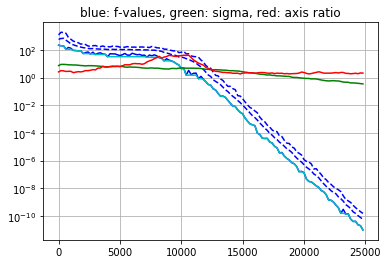

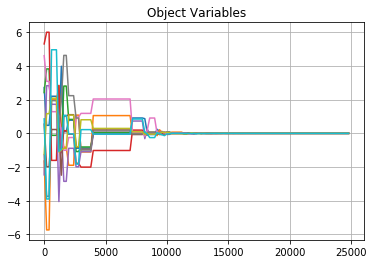

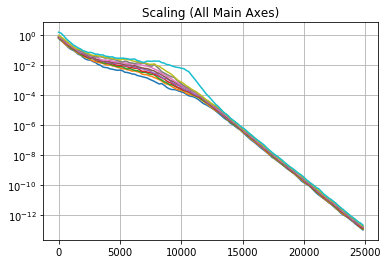

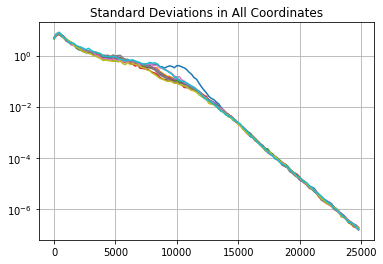

In [3]:
if __name__ == "__main__":
    # Problem size
    num_individuals = 10
    num_generations = 125

    # Create a strategy using CMA-ES algorithm
    strategy = cma.Strategy(centroid=[5.0]*num_individuals, sigma=5.0, 
            lambda_=20*num_individuals)

    # Create toolbox based on the above strategy
    toolbox = create_toolbox(strategy)

    # Create hall of fame object
    hall_of_fame = tools.HallOfFame(1)

    # Register the relevant stats
    stats = tools.Statistics(lambda x: x.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "std", "min", "avg", "max"
    
    # Objects that will compile the data
    sigma = np.ndarray((num_generations, 1))
    axis_ratio = np.ndarray((num_generations, 1))
    diagD = np.ndarray((num_generations, num_individuals))
    fbest = np.ndarray((num_generations,1))
    best = np.ndarray((num_generations, num_individuals))
    std = np.ndarray((num_generations, num_individuals))

    for gen in range(num_generations):
        # Generate a new population
        population = toolbox.generate()

        # Evaluate the individuals
        fitnesses = toolbox.map(toolbox.evaluate, population)
        for ind, fit in zip(population, fitnesses):
            ind.fitness.values = fit
        
        # Update the strategy with the evaluated individuals
        toolbox.update(population)
        
        # Update the hall of fame and the statistics with the
        # currently evaluated population
        hall_of_fame.update(population)
        record = stats.compile(population)
        logbook.record(evals=len(population), gen=gen, **record)
        
        print(logbook.stream)
        
        # Save more data along the evolution 
        sigma[gen] = strategy.sigma
        axis_ratio[gen] = max(strategy.diagD)**2/min(strategy.diagD)**2
        diagD[gen, :num_individuals] = strategy.diagD**2
        fbest[gen] = hall_of_fame[0].fitness.values
        best[gen, :num_individuals] = hall_of_fame[0]
        std[gen, :num_individuals] = np.std(population, axis=0)

    # The x-axis will be the number of evaluations
    x = list(range(0, strategy.lambda_ * num_generations, strategy.lambda_))
    avg, max_, min_ = logbook.select("avg", "max", "min")
    plt.figure()
    plt.semilogy(x, avg, "--b")
    plt.semilogy(x, max_, "--b")
    plt.semilogy(x, min_, "-b")
    plt.semilogy(x, fbest, "-c")
    plt.semilogy(x, sigma, "-g")
    plt.semilogy(x, axis_ratio, "-r")
    plt.grid(True)
    plt.title("blue: f-values, green: sigma, red: axis ratio")

    plt.figure()
    plt.plot(x, best)
    plt.grid(True)
    plt.title("Object Variables")

    plt.figure()
    plt.semilogy(x, diagD)
    plt.grid(True)
    plt.title("Scaling (All Main Axes)")

    plt.figure()
    plt.semilogy(x, std)
    plt.grid(True)
    plt.title("Standard Deviations in All Coordinates")
    
    plt.show()